# Individual Socioeconomic Status and the Placement of Public Art Installations within Vancouver

In [1]:
# load library
suppressPackageStartupMessages(
    {library("tidyr")
    library("dplyr")
    library(tidyverse)
    library("broom")
    library(car)
})

## outline
- Introduction
- Data Description
    - Summary Statistics **done**
- Model
    - Table of Results
- Discussion
- Conclusion
- References

## Introduction

**EDIT HERE!!!!**

Introduction: the introduction is the most important part of your paper. A good
introduction should do the following:
- Provide motivation for the paper: why should I care about this paper?
- Clearly and explicitly state the research question for the paper. What is this paper
going to find out?
- Provide key background: what do we know about the answer already?
- Give an overview of your results and what your paper will find: what did you learn?

Public art installations are widely used to foster public interaction, promote a sense of community, contribute to local identity, provoke thought or discussion, and tackle social exclusion (Schuermans, 2012). Our research aims to investigate how the levels of individual socioeconomic status in neighborhoods determine the placement of public art installations within Vancouver. We will follow a regular track for this project. 

## Data Description

Data Description: in the data description, you should focus on the following elements:
- What is the source of the data?  **done**
- How is the data structured? Are there any important features we need to understand?  **done**
- What are the important variables? Why are they important?  **done**
- How are the variables structured? Are there any necessary transformations needed?
- What is your analysis sample? Why or how was it constructed.

To conduct the analysis, we will use two primary datasets. 

The first one is the 2021 Canadian Census, including many variables at the Census Dissemination Area (DA) level, as the source of data on the socioeconomic status of different neighborhoods in Vancouver. Another dataset is a public art dataset that includes the titles, types, status, and locations of art installations in Vancouver. We will study our research topic by combining the information from these two datasets. 

For the measures of socioeconomic status, we will focus on the income and education level of people in different neighborhoods in Vancouver. For income variables, we will use the income Gini index, also the median income. To measure educational attainment, we will use the education level. In addition to education and income, we will include the population density variable in our model as a control to test whether the other variables affect the placement of public art in Vancouver.

In [2]:
public_art <- read_delim("data/public-art.csv")

head(public_art, n=3)

Rows: 695 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): Title of Work, ArtistProjectStatement, Type, Status, SiteName, Sit...
dbl  (2): RegistryID, YearOfInstallation
num  (1): Artists

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


RegistryID,Title of Work,ArtistProjectStatement,Type,Status,SiteName,SiteAddress,PrimaryMaterial,URL,PhotoURL,Ownership,Neighbourhood,LocationOnsite,Geom,Geo Local Area,DescriptionOfwork,Artists,PhotoCredits,YearOfInstallation,geo_point_2d
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,Captain George Vancouver,"A new city hall and a statue of Captain George Vancouver were commissioned to commemorate Vancouver's Golden Jubilee in 1936. The architect of the new City Hall at Strathcona Park on West 12th Avenue, Fred Townley, proposed the sculpture, commissioned by the Vancouver Canadian Club, be placed on the plaza on the north side of the building. Noted BC sculptor, Charles Marega, was commissioned (for about $5500) to create a life-size sculpture of the man who mapped the harbour in 1792 and after whom the city is named. Marega began by setting up 500 pounds of clay on a turntable in his Hornby Street Studio. From the clay model, he made a plaster cast which was then used to cast the finished work in ""Roman bronze"". It was cast at Ornamental Bronze, a foundry in Vancouver. The work was installed on August 20, 1936.The bronze figure standing atop the granite plinth is said to bear little physical resemblance to Captain George. The sculpture was copied from a maquette, which had been fashioned after a painting that was in turn, a copy from an original painting. An interesting conversation is recorded between Major Matthews, the City Archivist, and Townley. Matthews: ""Mr. Townley, the ""Sun"" newspaper wants to know how much the Vancouver statue cost and who paid for it."" Townley: ""What do they want to bring that up for? Leave sleeping dogs lie. I've been afraid that matter would come up, but it has not...why bring it up now? It was all in the contract; everything was above board; there's nothing to hide; but if it gets out what it cost, then some fool will start writing to the newspapers, or something, and complain of the waste of money; say it ought to have been given towards the support of some fool scheme of his own, the ""home for incurable dogs"", or some other idiotic thing"". Matthews: ""Alright; drop it, I don't want to know; the ""Sun"" is publishing a story on the statue, and I suppose they want to put the cost in."" Townley: ""Well, Charles Marega made it, and baby bonds paid for it...I don't know exactly what it cost; it would be hard to find out; part of it was in the stone work cost. Marega for $5000, and then there was the base; so much per square foot for the base, perhaps $500 for that..."" The statue was cleaned in 2001, 65 years after its installation and in time for the city's 115th birthday. The bill for cost of cleaning was $5800, almost the same amount as the original statue cost. This sculpture is on the City of Vancouver's Heritage Inventory list and, as a proud homage to a great explorer, has stood the test of time.",Figurative,In place,Vancouver City Hall,453 West 12th Avenue,bronze,https://covapp.vancouver.ca/PublicArtRegistry/ArtworkDetail.aspx?ArtworkId=1,https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/public-art/files/6dfd36260587f27540709ca506c4e81c,City of Vancouver,Mount Pleasant,"North entrance, exterior, in front of stairs","{""coordinates"": [-123.113918, 49.261185], ""type"": ""Point""}",Mount Pleasant,"A full figure bronze statue of Captain George Vancouver stands on the north side of City Hall, pointing towards Vancouver harbour and holding a partially open scroll in his left hand. The figure commemorates the events of 1792, when Captain George, a representative of King George III of England, sailed into Burrard Inlet and charted the area.",98,Barbara Cole,1936,"49.261185, -123.113918"
8,Charles Bentall,NA,Figurative,In place,Bentall Bldg.,505 Burrard Street,bronze,https://covapp.vancouver.ca/PublicArtRegistry/ArtworkDetail.aspx?ArtworkId=8,https://opendata.vancouver.ca/api/explore/v2.1/catalog/

Firstly, we calculate the art installation density in each neighborhood.

In [3]:
neighborhoods <- public_art |>
    group_by(Neighbourhood) |>
    summarize(art_count=n())

art_prop <- neighborhoods |>
    mutate(art_prop=art_count/nrow(public_art))

head(art_prop)

Neighbourhood,art_count,art_prop
<chr>,<int>,<dbl>
Arbutus Ridge,2,0.002877698
Downtown,212,0.305035971
DowntownEastside,51,0.073381295
Dunbar-Southlands,2,0.002877698
Fairview,18,0.025899281
Grandview-Woodland,21,0.030215827


We take the proportion of the number of art installations in a `Neighborhood` to the total number of art installations in Vancouver as our target variable.

We take this art installation density variable as our target variable Y. We need to merge this dataset with our explanatory variables Xs.

In [4]:
load('data/data_hoods_nosf.rda')
head(census_data_hood, n=3)

,Shape.Area,Quality.Flags,GeoUID,Type,Households,CD_UID,Dwellings,Population,name,CSD_UID,⋯,in_neighbourhood_West.End,in_neighbourhood_Downtown,in_neighbourhood_Hastings.Sunrise,in_neighbourhood_Kerrisdale,in_neighbourhood_Marpole,in_neighbourhood_Oakridge,in_neighbourhood_Riley.Park,in_neighbourhood_South.Cambie,in_neighbourhood_Shaughnessy,in_neighbourhood_Victoria-Fraserview
,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8517,0,59150004,DA,166,5915,177,362,59150004,5915055,⋯,0,0,0,0,0,0,0,0,0,0
2,0.1660,0,59150005,DA,205,5915,221,526,59150005,5915055,⋯,0,0,0,0,0,0,0,0,0,0
3,0.1559,0,59150006,DA,192,5915,199,452,59150006,5915055,⋯,0,0,0,0,0,0,0,0,0,0


We need to convert the dummy variables in the dataset to one categorical column.

In [5]:
dummy_cols <- c('in_neighbourhood_Arbutus.Ridge','in_neighbourhood_Grandview.Woodland','in_neighbourhood_Kensington.Cedar.Cottage',
                'in_neighbourhood_Killarney','in_neighbourhood_Kitsilano','in_neighbourhood_Strathcona','in_neighbourhood_Sunset','in_neighbourhood_West.Point.Grey',
                'in_neighbourhood_Dunbar.Southlands','in_neighbourhood_Fairview','in_neighbourhood_Mount.Pleasant','in_neighbourhood_Renfrew.Collingwood','in_neighbourhood_West.End',
                'in_neighbourhood_Downtown','in_neighbourhood_Hastings.Sunrise','in_neighbourhood_Kerrisdale','in_neighbourhood_Marpole','in_neighbourhood_Oakridge',
                'in_neighbourhood_Riley.Park','in_neighbourhood_South.Cambie','in_neighbourhood_Shaughnessy','in_neighbourhood_Victoria-Fraserview')

census_data_hood_long <- census_data_hood %>%
  pivot_longer(cols = all_of(dummy_cols), names_to = "variable", values_to = "value") %>%
  filter(value == 1) %>%
  group_by(GeoUID) %>%
  summarise(Neighbourhood = first(variable), .groups = "drop")

geouid_neighb <- census_data_hood %>%
  left_join(census_data_hood_long, by = "GeoUID") %>%
  select(GeoUID, Neighbourhood) %>%
  filter(!is.na(Neighbourhood))

In [6]:
head(geouid_neighb,n=3)
slice(geouid_neighb,300:302)

,GeoUID,Neighbourhood
,<chr>,<chr>
1,59150307,in_neighbourhood_Hastings.Sunrise
2,59150308,in_neighbourhood_Hastings.Sunrise
3,59150309,in_neighbourhood_Hastings.Sunrise


GeoUID,Neighbourhood
<chr>,<chr>
59150641,in_neighbourhood_Fairview
59150642,in_neighbourhood_Fairview
59150643,in_neighbourhood_Fairview


Now we rewrite the names of the neighborhood to the same ones as those in our public art dataset `art_prop`.

In [7]:
art_prop$Neighbourhood

[1] "Arbutus Ridge"            "Downtown"                
 [3] "DowntownEastside"         "Dunbar-Southlands"       
 [5] "Fairview"                 "Grandview-Woodland"      
 [7] "Hastings-Sunrise"         "Kensington-Cedar Cottage"
 [9] "Kerrisdale"               "Killarney"               
[11] "Kitsilano"                "Marpole"                 
[13] "Mount Pleasant"           "Oakridge"                
[15] "Renfrew-Collingwood"      "RileyPark"               
[17] "Shaughnessy"              "South Cambie"            
[19] "Stanley Park"             "Strathcona"              
[21] "Sunset"                   "Victoria-Fraserview"     
[23] "West End"                 "West Point Grey"         
[25] NA

In [8]:
geouid_neighb <- geouid_neighb %>%
  mutate(Neighbourhood = Neighbourhood %>%
           gsub('in_neighbourhood_Arbutus.Ridge', 'Arbutus Ridge', .) %>%
           gsub('in_neighbourhood_Downtown', 'Downtown', .) %>%
           gsub('in_neighbourhood_Dunbar.Southlands', 'Dunbar-Southlands', .) %>%
           gsub('in_neighbourhood_Fairview', 'Fairview', .) %>%
           gsub('in_neighbourhood_Grandview.Woodland', 'Grandview-Woodland', .) %>%
           gsub('in_neighbourhood_Hastings.Sunrise', 'Hastings-Sunrise', .) %>%
           gsub('in_neighbourhood_Kensington.Cedar.Cottage', 'Kensington-Cedar Cottage', .) %>%
           gsub('in_neighbourhood_Kerrisdale', 'Kerrisdale', .) %>%
           gsub('in_neighbourhood_Killarney', 'Killarney', .) %>%
           gsub('in_neighbourhood_Kitsilano', 'Kitsilano', .) %>%
           gsub('in_neighbourhood_Marpole', 'Marpole', .) %>%
           gsub('in_neighbourhood_Mount.Pleasant', 'Mount Pleasant', .) %>%
           gsub('in_neighbourhood_Oakridge', 'Oakridge', .) %>%
           gsub('in_neighbourhood_Renfrew.Collingwood', 'Renfrew-Collingwood', .) %>%
           gsub('in_neighbourhood_Riley.Park', 'RileyPark', .) %>%
           gsub('in_neighbourhood_Shaughnessy', 'Shaughnessy', .) %>%
           gsub('in_neighbourhood_South.Cambie', 'South Cambie', .) %>%
           # gsub('in_neighbourhood_Grandview.Woodland', 'Stanley Park', .) %>%
           gsub('in_neighbourhood_Strathcona', 'Strathcona', .) %>%
           gsub('in_neighbourhood_Sunset', 'Sunset', .) %>%
           gsub('in_neighbourhood_Victoria-Fraserview', 'Victoria-Fraserview', .) %>%
           gsub('in_neighbourhood_West.End', 'West End', .) %>%
           gsub('in_neighbourhood_West.Point.Grey', 'West Point Grey', .))

In [9]:
# check the modification
head(geouid_neighb,n=3)

,GeoUID,Neighbourhood
,<chr>,<chr>
1,59150307,Hastings-Sunrise
2,59150308,Hastings-Sunrise
3,59150309,Hastings-Sunrise


In [10]:
# load our census data
load('data/data_art_nosf.rda')

head(census_data_art, n=3)

,Shape.Area,Quality.Flags,GeoUID,Type,Households,CD_UID,Dwellings,Population,name,CSD_UID,⋯,v_CA21_7617..Total...Commuting.destination.for.the.employed.labour.force.aged.15.years.and.over.with.a.usual.place.of.work,v_CA21_7632..Total...Main.mode.of.commuting.for.the.employed.labour.force.aged.15.years.and.over.with.a.usual.place.of.work.or.no.fixed.workplace.address,v_CA21_7634..Total...Main.mode.of.commuting.for.the.employed.labour.force.aged.15.years.and.over.with.a.usual.place.of.work.or.no.fixed.workplace.address,v_CA21_7656..Total...Commuting.duration.for.the.employed.labour.force.aged.15.years.and.over.with.a.usual.place.of.work.or.no.fixed.workplace.address,v_CA21_7674..Total...Time.leaving.for.work.for.the.employed.labour.force.aged.15.years.and.over.with.a.usual.place.of.work.or.no.fixed.workplace.address,v_CA21_599..Income.statistics.in.2020.for.the.population.aged.15.years.and.over.in.private.households,v_CA21_851..Income.statistics.in.2019.for.the.population.aged.15.years.and.over.in.private.households,v_CA21_5865..Total...Highest.certificate..diploma.or.degree.for.the.population.aged.25.to.64.years.in.private.households,art_contained,art_within_500
,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8517,0,59150004,DA,166,5915,177,362,59150004,5915055,⋯,100,105,55,105,105,310,310,150,0,0
2,0.1660,0,59150005,DA,205,5915,221,526,59150005,5915055,⋯,125,175,95,175,175,380,380,235,0,0
3,0.1559,0,59150006,DA,192,5915,199,452,59150006,5915055,⋯,135,155,60,155,155,395,395,210,0,0


Since we are interested in the influence of socioeconomic factors in the public art installation density in an area, the important variables for us in this dataset are the population density, median income, income gini index and certificate density in each area in Vancouver, let us select them.

In [11]:
subset_data <- census_data_art %>% select("Region.Name",
                                          "Population",
                                          "v_CA21_6..Population.density.per.square.kilometre",
                                         "v_CA21_906..Median.total.income.of.household.in.2020....",
                                         "v_CA21_1140..Gini.index.on.adjusted.household.total.income",
                                         "v_CA21_5817..Total...Highest.certificate..diploma.or.degree.for.the.population.aged.15.years.and.over.in.private.households",
                                          ) |>
    rename(population_density = v_CA21_6..Population.density.per.square.kilometre,
           median_income = v_CA21_906..Median.total.income.of.household.in.2020....,
           gini_income = v_CA21_1140..Gini.index.on.adjusted.household.total.income,
           highest_certificate = v_CA21_5817..Total...Highest.certificate..diploma.or.degree.for.the.population.aged.15.years.and.over.in.private.households,
           GeoUID = Region.Name
          ) |>
    mutate(certificate_density = highest_certificate/Population,
          ) |>
    select(-highest_certificate, -Population)

head(subset_data, n=4)

,GeoUID,population_density,median_income,gini_income,certificate_density
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,59150004,425.0,105000,0.448,0.8563536
2,59150005,3168.7,122000,0.362,0.7319392
3,59150006,2899.3,103000,0.440,0.8738938
4,59150007,755.8,164000,0.478,0.8165138


Now we can merge the datasets of public art and our census, by using the `GeoUID` information in our neiborghhood dataset.

In [12]:
subset_data_neighb <- geouid_neighb %>%
  left_join(subset_data, by = "GeoUID")

In [13]:
clean_data <- subset_data_neighb %>%
  left_join(art_prop, by = "Neighbourhood") %>%
  select(-GeoUID) %>%
  group_by(Neighbourhood) %>%
  summarize(
    mean_population_density = mean(population_density, na.rm = TRUE),
    mean_median_income = mean(median_income, na.rm = TRUE),
    mean_gini_income = mean(gini_income, na.rm = TRUE),
    mean_certificate_density = mean(certificate_density, na.rm = TRUE),
    art_count = mean(art_count, na.rm = TRUE)   # same value for the same neighborhood
  )

head(clean_data,n=3)

Neighbourhood,mean_population_density,mean_median_income,mean_gini_income,mean_certificate_density,art_count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Arbutus Ridge,5360.252,106915.0,0.4804000,0.8693448,2
Downtown,31467.572,84562.0,0.4448200,0.8726615,212
Dunbar-Southlands,3407.489,127083.3,0.4796667,0.8536720,2


In [14]:
nrow(clean_data)

[1] 22

### - Summary Statistics

In [15]:
summary_stats_Y <- clean_data |>
    summarize(
        mean = mean(art_count, na.rm = TRUE),
        max = max(art_count, na.rm = TRUE),
        sd = sd(art_count, na.rm = TRUE)
    ) |>
    mutate(variable = "art_count") |>
    select(variable, everything())

new_rows <- data.frame(
    variable = c("population_density", "median_income", "gini_income", "certificate_density"),
    mean = c(mean(subset_data$population_density, na.rm = TRUE), mean(subset_data$median_income, na.rm = TRUE), mean(subset_data$gini_income, na.rm = TRUE), mean(subset_data$certificate_density, na.rm = TRUE)),
    max = c(max(subset_data$population_density, na.rm = TRUE), max(subset_data$median_income, na.rm = TRUE), max(subset_data$gini_income, na.rm = TRUE), max(subset_data$certificate_density, na.rm = TRUE)),
    sd = c(sd(subset_data$population_density, na.rm = TRUE), sd(subset_data$median_income, na.rm = TRUE), sd(subset_data$gini_income, na.rm = TRUE), sd(subset_data$certificate_density, na.rm = TRUE))
)

summary_stats <- summary_stats_Y |>
    rbind(new_rows)

summary_stats |>
   mutate_if(is.numeric, round, 4)

variable,mean,max,sd
<chr>,<dbl>,<dbl>,<dbl>
art_count,23.9545,212.0000,44.5148
population_density,6457.5899,76474.4000,7609.1689
median_income,100413.3845,260000.0000,27239.0355
gini_income,0.3309,0.7520,0.0800
certificate_density,0.8483,1.2154,0.0926


Here is the summary statistic table of the key variables we will use in your analysis.

## Model

In [16]:
# # log the target variable to meet the assumptions
# clean_data <- clean_data %>%
#   mutate(art_count = log(art_count)) 

In [17]:
model <- lm(art_count~.-Neighbourhood, data=clean_data)

tidy(summary(model))%>% mutate_if(is.numeric, round, 5)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),171.70924,192.42171,0.89236,0.38466
mean_population_density,0.00683,0.00111,6.17006,0.00001
mean_median_income,0.00095,0.00051,1.88413,0.07677
mean_gini_income,-27.72702,110.69159,-0.25049,0.80521
mean_certificate_density,-334.49025,223.70224,-1.49525,0.15318


- positive association
- negative
- - pvalues  (significance level of 0.05)
- intercept: other better inferential features? but good normality in the error term (see in the next section)

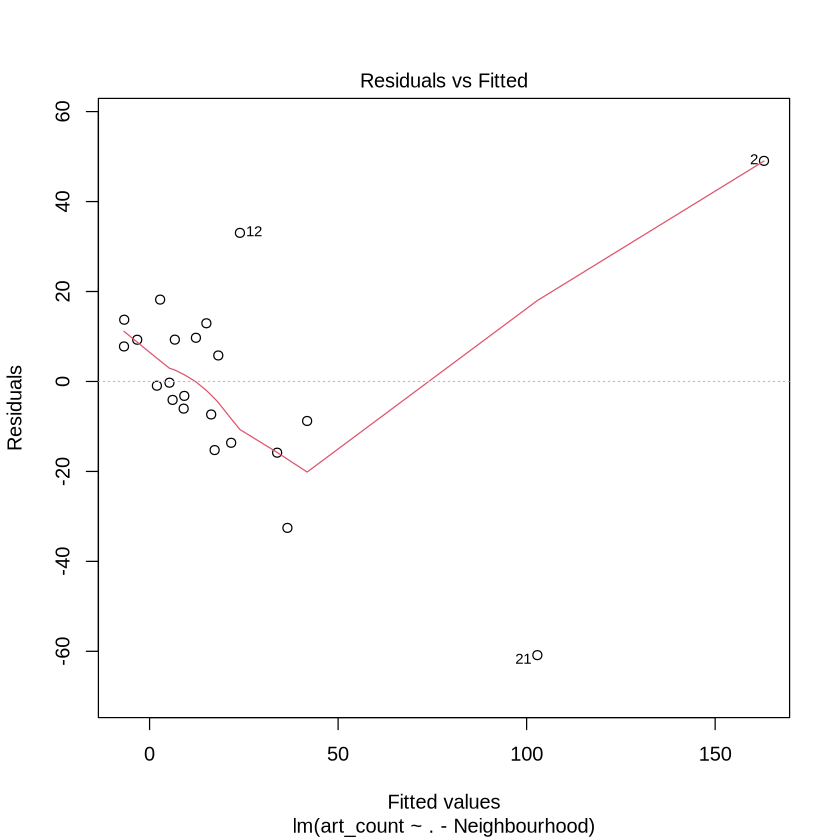

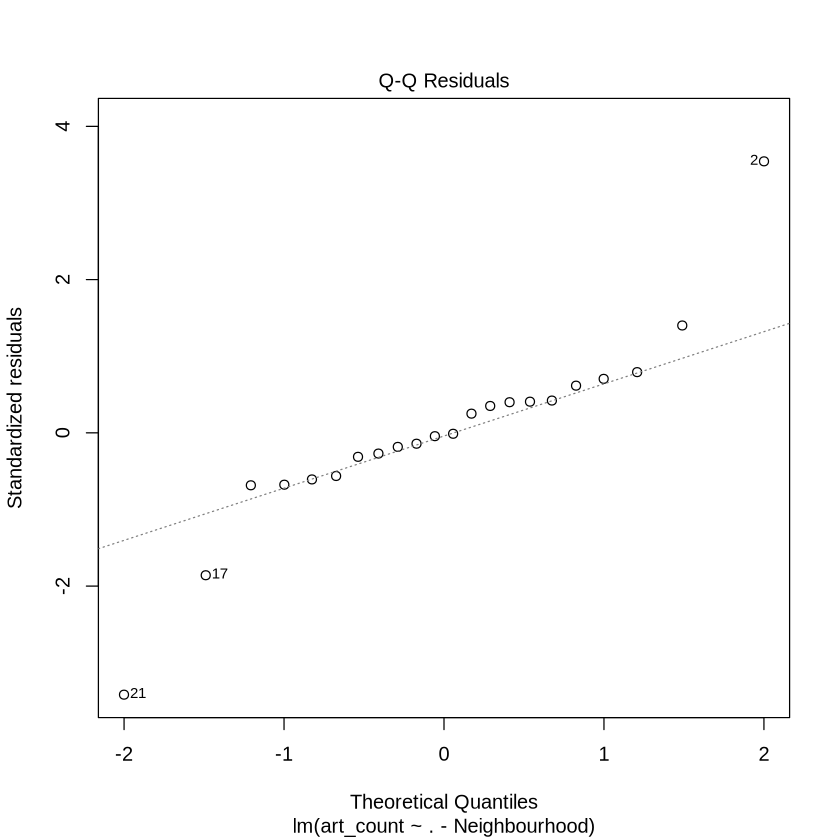

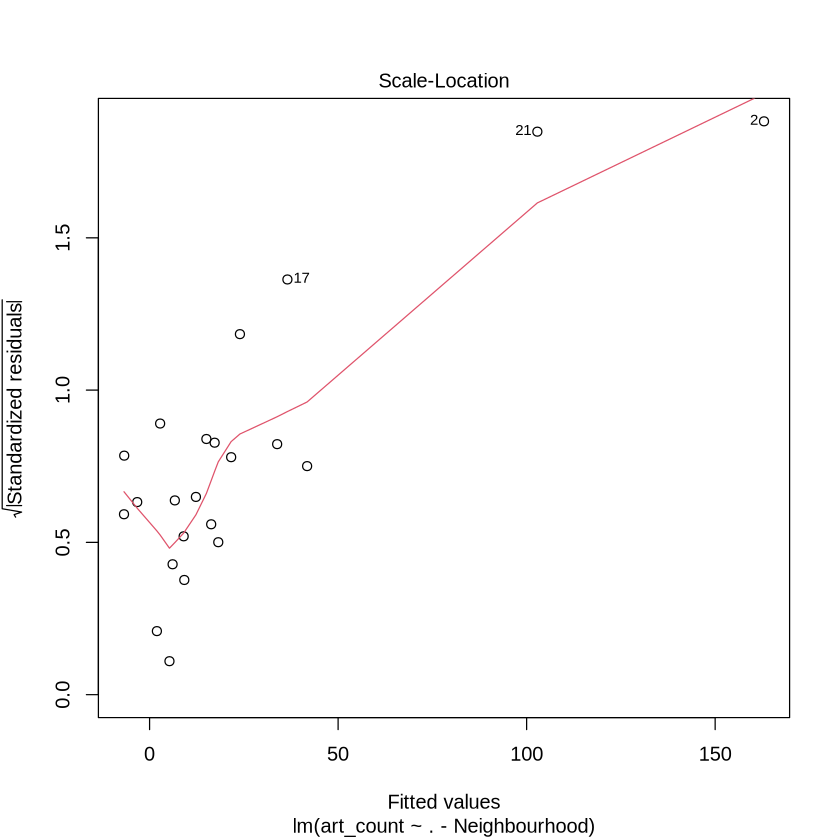

In [18]:
plot(model, which = 1)   
plot(model, which = 2)   
plot(model, which = 3)

In [19]:
# find outliers
std_residuals <- rstandard(model)

outliers <- which(abs(std_residuals) > 3)
outliers

2 21 
 2 21

In [20]:
# remove outliers
clean_data <- clean_data[-outliers, ]

new_model <- lm(art_count ~ .-Neighbourhood, data = clean_data)
tidy(summary(new_model))%>% mutate_if(is.numeric, round, 5)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-101.89262,106.59067,-0.95592,0.35426
mean_population_density,0.00422,0.00154,2.73074,0.01547
mean_median_income,0.00030,0.00032,0.94669,0.35880
mean_gini_income,20.21909,54.61889,0.37018,0.71642
mean_certificate_density,56.40281,121.71540,0.46340,0.64973


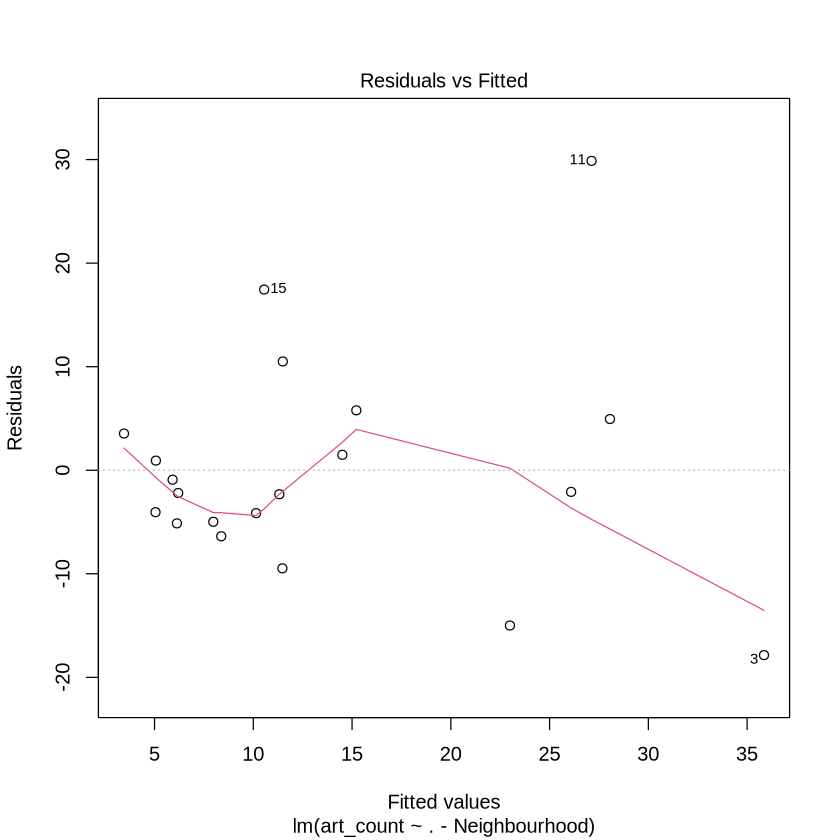

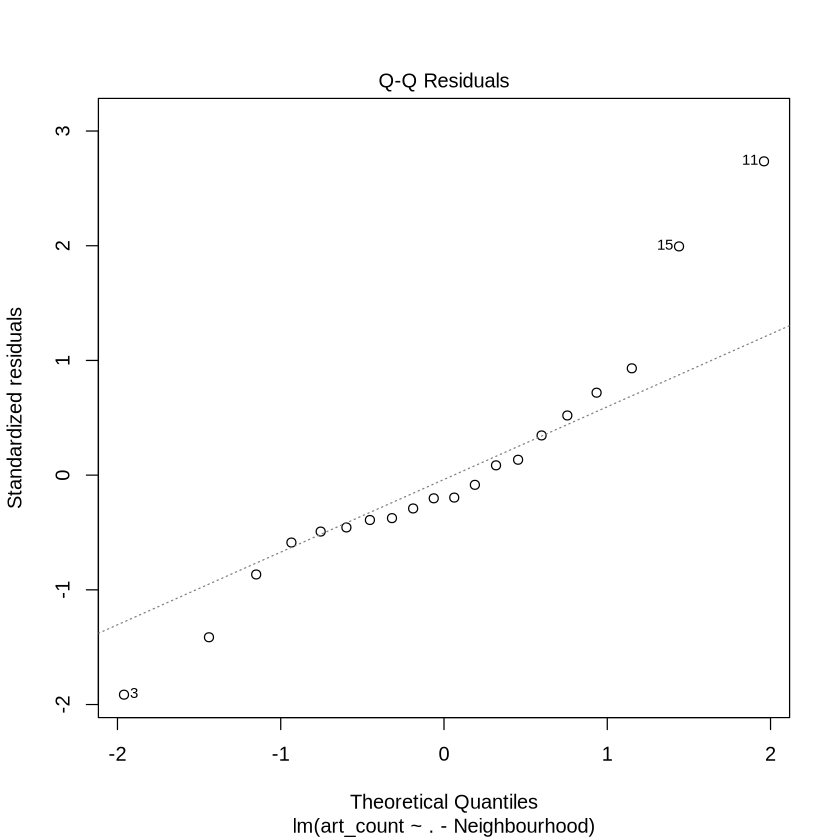

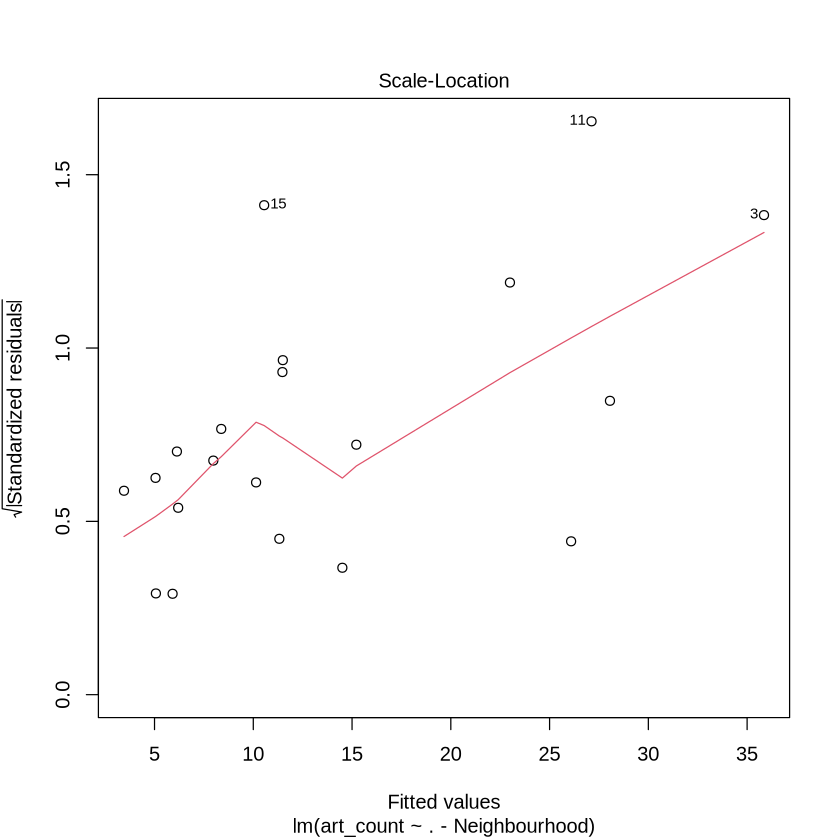

In [21]:
# plots to check Linearity, Homoscedasticity and Normality of residuals

plot(new_model, which = 1)  # Residuals vs Fitted
plot(new_model, which = 2)  # Q-Q plot for Error Term Normality
plot(new_model, which = 3) # Scale-Location Plot for Homoscedasticity

- not very good linearity
- good normality in error term
- heteroscedasticity

In [22]:
vif_values <- vif(model)
print(vif_values)

 mean_population_density       mean_median_income         mean_gini_income 
                2.321396                 3.750051                 2.411733 
mean_certificate_density 
                1.183762 


- Ignorable multicollinearity

## - Table of Results

## Discussion

## Conclusion


## References

1. Public art. (2024). Vancouver.ca. https://opendata.vancouver.ca/explore/dataset/public-art/export/?location=13,49.26603,-123.14601
(2021). Censusmapper.ca. https://censusmapper.ca/api/CA21#13/49.2717/-123.1262

2. Schuermans, N., Loopmans, M. P. J., & Vandenabeele, J. (2012). Public space, public art and public pedagogy. Social & Cultural Geography, 13(7), 675–682. https://doi.org/10.1080/14649365.2012.728007
